In [ ]:
from fastai.basics import *
from fastai.vision.core import *
from fastai.vision.data import *
from fastai.vision.augment import *
from fastai.vision.models.unet import *
from fastai.vision.learner import *
from fastai.vision.models import *
from fastai.callback.wandb import *
import wandb 
from sklearn.model_selection import KFold

FocalLoss was bugged in my version of fastai, so backported it here. 

In [ ]:
class FocalLoss(Module):
    y_int=True
    def __init__(self, gamma: float = 2.0, weight=None, reduction: str = 'mean') -> None:
        store_attr()

    def forward(self, inp: torch.Tensor, targ: torch.Tensor):
        ce_loss = F.cross_entropy(inp, targ, weight=self.weight, reduction="none")
        p_t = torch.exp(-ce_loss)
        loss = (1 - p_t)**self.gamma * ce_loss
        if self.reduction == "mean":
            loss = loss.mean()
        elif self.reduction == "sum":
            loss = loss.sum()
        return loss
    def decodes(self, x): 
        return x.argmax(dim=1)
    def activation(self, x): 
        return F.softmax(x, dim=1)

I tend to use wandb to track experiments. I find it is very useful for comparing across multiple runs. 

In [ ]:
wandb.init(project="mvtec")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: marii (use `wandb login --relogin` to force relogin)


#### Getting the data

Dataset: https://www.mvtec.com/company/research/datasets/mvtec-ad

In [ ]:
data_url='https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420938113-1629952094/mvtec_anomaly_detection.tar.xz'

In [ ]:
dest=Path('/home/molly/.fastai/data/mvtec')

Fastai doesn't recognize `.xz` files so we add that functionality here. 

In [ ]:
def file_extract(fname, dest=None):
    "Extract `fname` to `dest` using `tarfile` or `zipfile`."
    if dest is None: dest = Path(fname).parent
    fname = str(fname)
    if   fname.endswith('gz'):  tarfile.open(fname, 'r:gz').extractall(dest)
    elif fname.endswith('xz'):  tarfile.open(fname, 'r:xz').extractall(dest)
    elif fname.endswith('zip'): zipfile.ZipFile(fname     ).extractall(dest)
    else: raise Exception(f'Unrecognized archive: {fname}')

In [ ]:
path=untar_data(data_url,dest=dest,extract_func=file_extract) #breaks with '-' dashes?
path=path.parent
path.absolute()

Path('/home/molly/.fastai/data/mvtec')

We get all the carpet images that contain defects

In [ ]:
carpet_path=path/'carpet'/'test'
defect_folders=carpet_path.ls().map(lambda p:p.stem).filter(lambda p:p!='good')
image_files=get_image_files(carpet_path,folders=defect_folders)
len(image_files)

89

Choosing to show these images does to ease of seeing defects

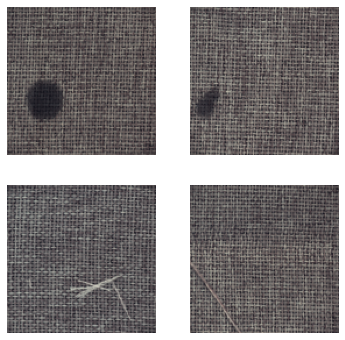

In [ ]:
imgs=[array(Image.open(img).resize((128,128))) for img in image_files[0,10,78,87]]
show_images(imgs,nrows=2)

#### Setting up the DataLoader

Due to the low data situation we do `KFold` with 10 splits. 

In [ ]:
kf = KFold(n_splits=10, shuffle=True) #kfold, as we have little data
valid_idxs=L(map(lambda s:s[1],kf.split(range(len(image_files)))))

In [ ]:
def label_func(p): return p.parent.parent.parent/'ground_truth'/p.parent.stem/(p.stem+'_mask'+p.suffix)

Because of the little data, we start training with lots of image augmentation, and decrease this latter in training.

In [ ]:
image_tfms=aug_transforms(mult=1.0,
    do_flip=True,
    flip_vert=True,
    max_rotate=180.0,
    size=(128,128),
    min_zoom=1.0,
    max_zoom=4.,
    max_lighting=0.5,
    max_warp=0.2,
    p_affine=0.75,
    p_lighting=0.75,
    xtra_tfms=[Saturation(max_lighting=0.5, p=0.75),
               Hue(max_hue=0.5, p=0.75)],
    mode='bilinear',
    pad_mode='reflection',
    align_corners=True,
    batch=False,
    min_scale=1.0,)

Create the DataBlock here. Realized the mask values are two values [0,255]. Divided by 255, where `div_mask=255.` This makes the mask values [0,1]

In [ ]:
mvtec = DataBlock(blocks=(ImageBlock, MaskBlock(['good','bad'])),
                   get_items = partial(get_image_files,folders=defect_folders),
                   get_y = label_func,
                   splitter=IndexSplitter(valid_idxs[0]),
                   batch_tfms=image_tfms+[IntToFloatTensor(div_mask=255.) ])

In [ ]:
dls = mvtec.dataloaders(carpet_path,bs=16)

/home/molly/miniconda3/envs/fastai/lib/python3.8/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
/home/molly/miniconda3/envs/fastai/lib/python3.8/site-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.


While being very different from our intended task, the heavy image augmentation allowed for longer training times in the training of the unfrozen model, and slightly (~0.02) better vailidation loss. 

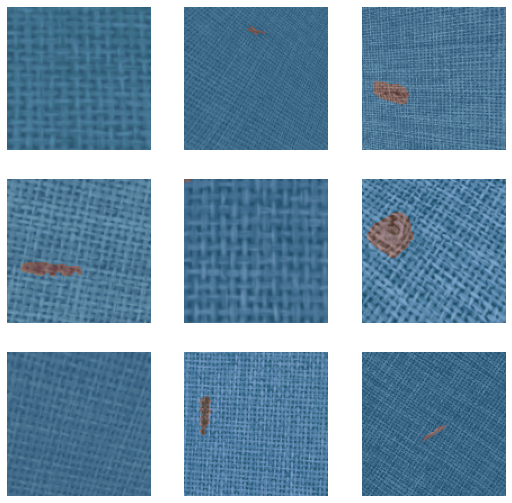

In [ ]:
dls.show_batch()

#### Training Frozen Model

We use the `JaccardCoeff`, becuase of its ease of interpretability as it is that same as "intersection over union". 

In [ ]:
IoU=JaccardCoeff()

We are now ready to train on the frozen model. Note: I did use `lr_find` but found that the parameter state wasn't being reset, so I did not run it after finding the correct `lr`. 

In [ ]:
learn = unet_learner(dls, resnet101,loss_func=FocalLoss(),cbs=[WandbCallback],metrics=[Dice(),IoU]).to_fp16()
learn.freeze()
#learn.lr_find() 

/home/molly/miniconda3/envs/fastai/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [ ]:
learn.fit_one_cycle(8,lr_max=1e-4)

WandbCallback requires use of "SaveModelCallback" to log best model


epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.062543,0.065475,0.000000,0.000000,00:13
1,0.069564,0.085630,0.000000,0.000000,00:08
2,0.061256,0.047735,0.000000,0.000000,00:08
3,0.057923,0.033252,0.000000,0.000000,00:08
4,0.056330,0.028235,0.000000,0.000000,00:08
5,0.051727,0.023363,0.000000,0.000000,00:08
6,0.048959,0.018886,0.000000,0.000000,00:08
7,0.047166,0.014675,0.000000,0.000000,00:08


#### Training Unfrozen Model

In [ ]:
mvtec = DataBlock(blocks=(ImageBlock, MaskBlock(['good','bad'])),
                   get_items = partial(get_image_files,folders=defect_folders),
                   get_y = label_func,
                   splitter=IndexSplitter(valid_idxs[0]),
                   batch_tfms=aug_transforms(size=(256,256))+[IntToFloatTensor(div_mask=255.) ])
dls = mvtec.dataloaders(carpet_path,bs=8)
learn.dls=dls

In [ ]:
learn.unfreeze()
#learn.lr_find()

In [ ]:
learn.fit_one_cycle(16,lr_max=1e-4)

epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.023414,1.581577,0.026961,0.013665,00:18
1,0.017576,0.330932,0.092003,0.048220,00:12
2,0.015308,0.031068,0.145593,0.078512,00:12
3,0.012882,0.013754,0.238421,0.135345,00:12
4,0.011003,0.010004,0.521456,0.352682,00:12
5,0.009974,0.007410,0.652251,0.483955,00:12
6,0.009084,0.010051,0.237997,0.135072,00:12
7,0.008734,0.008570,0.607997,0.436779,00:12
8,0.008085,0.006348,0.686983,0.523209,00:12
9,0.007420,0.008160,0.649609,0.481053,00:12


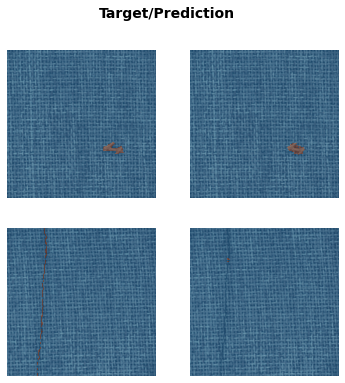

In [ ]:
learn.show_results(max_n=2)

#### K-fold, with 10 splits. 

WandbCallback requires use of "SaveModelCallback" to log best model


epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.076231,0.069928,0.002242,0.001122,00:08
1,0.064146,0.088197,0.000000,0.000000,00:08
2,0.056777,0.073511,0.000000,0.000000,00:08
3,0.054862,0.031052,0.000000,0.000000,00:08
4,0.051588,0.022723,0.000000,0.000000,00:08
5,0.049759,0.019107,0.000000,0.000000,00:08
6,0.047619,0.017284,0.000000,0.000000,00:08
7,0.046892,0.015337,0.000000,0.000000,00:08


epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.028064,0.088450,0.071831,0.037254,00:12
1,0.021040,0.029935,0.317427,0.188656,00:12
2,0.016645,0.031220,0.156275,0.084761,00:12
3,0.013802,0.012754,0.332731,0.199566,00:12
4,0.011615,0.017173,0.319892,0.190400,00:12
5,0.010351,0.008491,0.644817,0.475816,00:12
6,0.009328,0.006175,0.649538,0.480974,00:12
7,0.008499,0.007247,0.671907,0.505918,00:12
8,0.007666,0.006748,0.686575,0.522736,00:12
9,0.007045,0.008079,0.636441,0.466750,00:12


WandbCallback requires use of "SaveModelCallback" to log best model


epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.100611,0.102515,0.000000,0.000000,00:08
1,0.072306,0.087947,0.000000,0.000000,00:08
2,0.061522,0.058950,0.000000,0.000000,00:08
3,0.056684,0.050244,0.000000,0.000000,00:08
4,0.053005,0.048313,0.000000,0.000000,00:08
5,0.051112,0.041227,0.000000,0.000000,00:08
6,0.050056,0.038250,0.000000,0.000000,00:08
7,0.047448,0.039600,0.000000,0.000000,00:08


epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.026987,0.556744,0.109145,0.057722,00:12
1,0.020354,0.073364,0.022261,0.011256,00:12
2,0.028428,0.032038,0.099018,0.052088,00:12
3,0.024112,0.018809,0.585712,0.414139,00:12
4,0.019640,0.014783,0.674267,0.508600,00:12
5,0.016248,0.013037,0.720967,0.563681,00:12
6,0.013685,0.013745,0.715713,0.557285,00:12
7,0.011845,0.009235,0.808828,0.679019,00:12
8,0.010507,0.008043,0.835553,0.717553,00:12
9,0.009468,0.012859,0.689911,0.526614,00:12


WandbCallback requires use of "SaveModelCallback" to log best model


epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.141719,0.072013,0.000000,0.000000,00:08
1,0.096083,0.064990,0.000000,0.000000,00:08
2,0.081185,0.067321,0.000000,0.000000,00:08
3,0.069138,0.047111,0.000000,0.000000,00:08
4,0.060530,0.034739,0.000000,0.000000,00:08
5,0.053393,0.025006,0.000000,0.000000,00:08
6,0.049315,0.023478,0.000000,0.000000,00:08
7,0.048045,0.019965,0.000578,0.000289,00:08


epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.024412,0.851256,0.072288,0.037499,00:12
1,0.020662,0.018757,0.609706,0.438544,00:12
2,0.016414,0.040549,0.278553,0.161813,00:12
3,0.013471,0.015205,0.666667,0.500000,00:12
4,0.011904,0.007676,0.695704,0.533395,00:12
5,0.010934,0.005922,0.819437,0.694107,00:12
6,0.009966,0.005197,0.798390,0.664434,00:12
7,0.009039,0.004686,0.846365,0.733651,00:12
8,0.008119,0.004567,0.850854,0.740423,00:12
9,0.007416,0.004978,0.828891,0.707782,00:12


WandbCallback requires use of "SaveModelCallback" to log best model


epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.369563,0.073468,0.000000,0.000000,00:08
1,0.205162,0.045831,0.000000,0.000000,00:08
2,0.154992,0.062972,0.000000,0.000000,00:08
3,0.125761,0.055315,0.000000,0.000000,00:08
4,0.102902,0.050849,0.000000,0.000000,00:08
5,0.088529,0.039470,0.000000,0.000000,00:08
6,0.078991,0.036676,0.000000,0.000000,00:08
7,0.072668,0.032800,0.000000,0.000000,00:08


epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.027126,0.332864,0.042624,0.021776,00:12
1,0.021270,0.019107,0.458976,0.297839,00:12
2,0.016262,0.012245,0.598375,0.426916,00:12
3,0.015351,0.016163,0.385347,0.238656,00:12
4,0.013478,0.005883,0.729578,0.574281,00:12
5,0.011696,0.005326,0.764792,0.619160,00:12
6,0.010258,0.006472,0.712117,0.552936,00:12
7,0.009096,0.004875,0.772276,0.629031,00:12
8,0.008239,0.004580,0.777607,0.636136,00:12
9,0.007545,0.004225,0.820278,0.695314,00:12


WandbCallback requires use of "SaveModelCallback" to log best model


epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.230904,0.058536,0.000000,0.000000,00:08
1,0.145042,0.066735,0.000000,0.000000,00:08
2,0.301269,0.032963,0.000000,0.000000,00:08
3,0.246067,0.075106,0.000000,0.000000,00:08
4,0.198077,0.046551,0.000000,0.000000,00:08
5,0.168880,0.047111,0.000000,0.000000,00:08
6,0.146629,0.029702,0.000000,0.000000,00:08
7,0.128967,0.028106,0.000000,0.000000,00:08


epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.028811,0.073077,0.108003,0.057084,00:12
1,0.024257,0.114730,0.152258,0.082402,00:12
2,0.019471,0.033845,0.250190,0.142981,00:12
3,0.015670,0.015577,0.597460,0.425984,00:12
4,0.013397,0.026251,0.284993,0.166176,00:12
5,0.013669,0.007087,0.716762,0.558558,00:12
6,0.012127,0.006340,0.750422,0.600540,00:12
7,0.011050,0.006862,0.720359,0.562938,00:12
8,0.009960,0.006346,0.740899,0.588435,00:12
9,0.008996,0.006060,0.741217,0.588836,00:12


WandbCallback requires use of "SaveModelCallback" to log best model


epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.063896,0.065843,0.000000,0.000000,00:08
1,0.080949,0.078137,0.000000,0.000000,00:08
2,0.076567,0.078124,0.000000,0.000000,00:08
3,0.068093,0.052065,0.000000,0.000000,00:08
4,0.063133,0.027515,0.000000,0.000000,00:08
5,0.059667,0.024673,0.000000,0.000000,00:08
6,0.056586,0.014785,0.000000,0.000000,00:08
7,0.053818,0.013735,0.000000,0.000000,00:08


epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.028476,0.062381,0.037479,0.019097,00:12
1,0.021708,0.062645,0.028671,0.014544,00:12
2,0.018949,0.010992,0.542276,0.372002,00:12
3,0.015253,0.011735,0.320725,0.190990,00:12
4,0.013125,0.005789,0.565505,0.394219,00:12
5,0.011524,0.002853,0.780217,0.639636,00:12
6,0.010187,0.002733,0.755296,0.606808,00:12
7,0.009115,0.002767,0.750000,0.600000,00:12
8,0.008228,0.002835,0.759500,0.612253,00:12
9,0.007564,0.002226,0.794622,0.659231,00:12


WandbCallback requires use of "SaveModelCallback" to log best model


epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.064665,0.097435,0.000000,0.000000,00:08
1,0.063309,0.057254,0.000000,0.000000,00:08
2,0.057749,0.070073,0.000000,0.000000,00:08
3,0.051387,0.044729,0.000000,0.000000,00:08
4,0.046936,0.037515,0.000000,0.000000,00:08
5,0.048593,0.047619,0.000000,0.000000,00:08
6,0.047224,0.036497,0.000000,0.000000,00:08
7,0.045708,0.037233,0.000000,0.000000,00:08


epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.027333,0.250195,0.010844,0.005451,00:12
1,0.020305,4.623504,0.118016,0.062708,00:12
2,0.019676,0.033730,0.596336,0.424842,00:12
3,0.016133,0.013813,0.764175,0.618352,00:12
4,0.013338,0.010026,0.803904,0.672106,00:12
5,0.011542,0.010359,0.784680,0.645656,00:12
6,0.010093,0.007122,0.836482,0.718925,00:12
7,0.008978,0.006683,0.844835,0.731354,00:12
8,0.008181,0.007945,0.818425,0.692656,00:12
9,0.007489,0.006506,0.838576,0.722024,00:12


WandbCallback requires use of "SaveModelCallback" to log best model


epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.058948,0.089513,0.000000,0.000000,00:08
1,0.055569,0.054830,0.000000,0.000000,00:08
2,0.052294,0.075969,0.000000,0.000000,00:08
3,0.053137,0.046452,0.000000,0.000000,00:08
4,0.051959,0.029520,0.000000,0.000000,00:08
5,0.049913,0.027398,0.000000,0.000000,00:08
6,0.048199,0.025849,0.000000,0.000000,00:08
7,0.047808,0.024530,0.000000,0.000000,00:08


epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.026873,0.133182,0.103035,0.054316,00:12
1,0.021057,0.043840,0.359161,0.218888,00:12
2,0.019935,0.022695,0.358556,0.218439,00:12
3,0.015782,0.016473,0.557734,0.386707,00:12
4,0.013157,0.010159,0.661406,0.494105,00:12
5,0.011350,0.005418,0.806017,0.675065,00:12
6,0.010195,0.005115,0.806251,0.675394,00:12
7,0.009026,0.006212,0.756496,0.608359,00:12
8,0.008189,0.004603,0.814607,0.687205,00:12
9,0.007427,0.004402,0.828613,0.707377,00:12


WandbCallback requires use of "SaveModelCallback" to log best model


epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.085197,0.057964,0.000000,0.000000,00:08
1,0.060986,0.088152,0.026778,0.013571,00:08
2,0.105223,0.053687,0.000000,0.000000,00:08
3,0.089669,0.065778,0.000000,0.000000,00:08
4,0.083271,0.046291,0.000000,0.000000,00:08
5,0.075050,0.029387,0.000000,0.000000,00:08
6,0.071043,0.029412,0.000000,0.000000,00:08
7,0.065956,0.028484,0.000000,0.000000,00:08


epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.031075,0.137229,0.090042,0.047143,00:12
1,0.024293,0.077144,0.317029,0.188375,00:12
2,0.019522,0.021719,0.508452,0.340889,00:12
3,0.016450,0.013061,0.491015,0.325394,00:12
4,0.014479,0.009179,0.418841,0.264895,00:12
5,0.012476,0.005671,0.768746,0.624360,00:12
6,0.010932,0.005312,0.768426,0.623939,00:12
7,0.009812,0.005534,0.759287,0.611976,00:12
8,0.008870,0.005053,0.791183,0.654509,00:12
9,0.008061,0.004721,0.797511,0.663216,00:12


WandbCallback requires use of "SaveModelCallback" to log best model


epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.064797,0.071965,0.000000,0.000000,00:09
1,0.054895,0.058643,0.000000,0.000000,00:08
2,0.049651,0.046204,0.000000,0.000000,00:08
3,0.050465,0.032035,0.000000,0.000000,00:08
4,0.049929,0.041927,0.000000,0.000000,00:08
5,0.046109,0.024885,0.000000,0.000000,00:08
6,0.044153,0.022557,0.000000,0.000000,00:08
7,0.044071,0.021347,0.000000,0.000000,00:08


epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.025879,0.129891,0.042176,0.021542,00:12
1,0.020290,0.035990,0.144406,0.077822,00:12
2,0.017499,0.052359,0.004480,0.002245,00:12
3,0.014745,0.010033,0.627682,0.457389,00:12
4,0.012806,0.006360,0.700896,0.539522,00:12
5,0.011091,0.006492,0.691084,0.527982,00:12
6,0.009799,0.006385,0.626394,0.456022,00:12
7,0.008651,0.006585,0.673984,0.508278,00:12
8,0.007867,0.006976,0.554454,0.383560,00:12
9,0.007253,0.007228,0.637119,0.467479,00:12


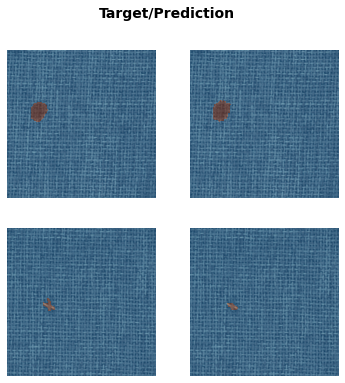

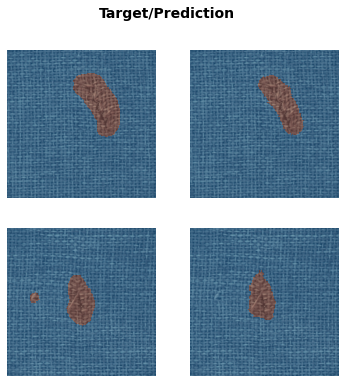

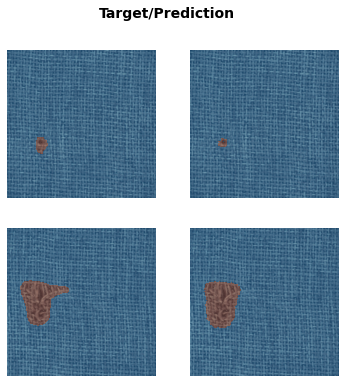

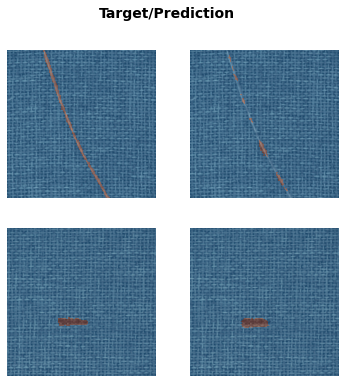

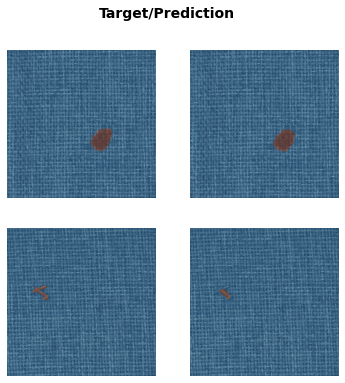

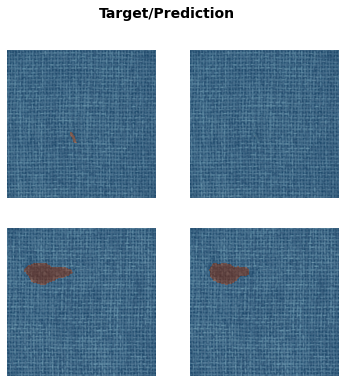

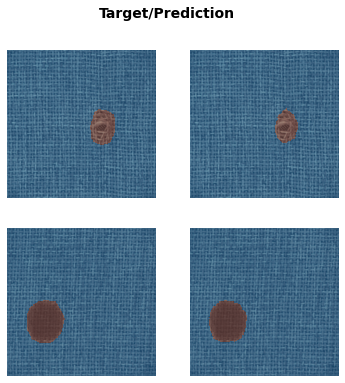

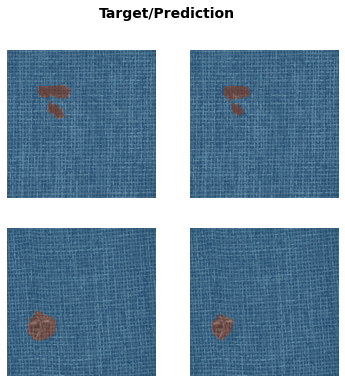

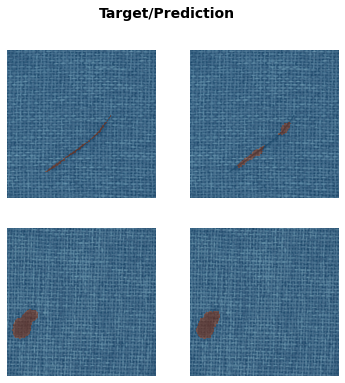

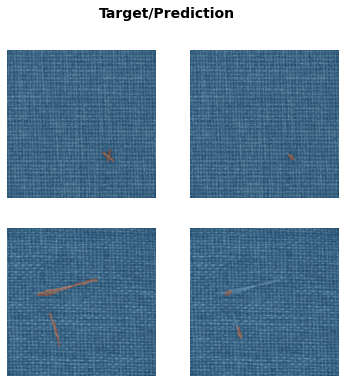

In [ ]:
metrics=L()
for valid_idx in valid_idxs:
    del learn.opt
    del learn.model
    del learn.dls
    del learn
    del dls
    torch.cuda.empty_cache()
    mvtec = DataBlock(blocks=(ImageBlock, MaskBlock(['good','bad'])),
                   get_items = partial(get_image_files,folders=defect_folders),
                   get_y = label_func,
                   splitter=IndexSplitter(valid_idx),
                   batch_tfms=image_tfms+[IntToFloatTensor(div_mask=255.) ])
    dls = mvtec.dataloaders(carpet_path,bs=16)
    learn = unet_learner(dls, resnet101,loss_func=FocalLoss(),cbs=[WandbCallback],metrics=[Dice(),IoU]).to_fp16()
    learn.freeze()
    learn.fit_one_cycle(8,lr_max=1e-4)
    mvtec = DataBlock(blocks=(ImageBlock, MaskBlock(['good','bad'])),
                   get_items = partial(get_image_files,folders=defect_folders),
                   get_y = label_func,
                   splitter=IndexSplitter(valid_idx),
                   batch_tfms=aug_transforms(size=(256,256))+[IntToFloatTensor(div_mask=255.) ])
    dls = mvtec.dataloaders(carpet_path,bs=8)
    learn.dls=dls
    learn.unfreeze()
    learn.fit_one_cycle(16,lr_max=1e-4)
    metrics+=learn.metrics.map(lambda m:m.value)
    learn.show_results(max_n=2)

In [ ]:
dice_scores=array(metrics[::2])
iou_scores =array(metrics[1::2])

#### Final metrics and top losses

In [ ]:
print("Dice Mean: %.3f ±%.2f" % (dice_scores.mean(),dice_scores.std()))
print("IoU Mean:  %.3f ±%.2f" % (iou_scores.mean(),iou_scores.std()))

Dice Mean: 0.781 ±0.07
IoU Mean:  0.645 ±0.09


In [ ]:
interp = Interpretation.from_learner(learn)

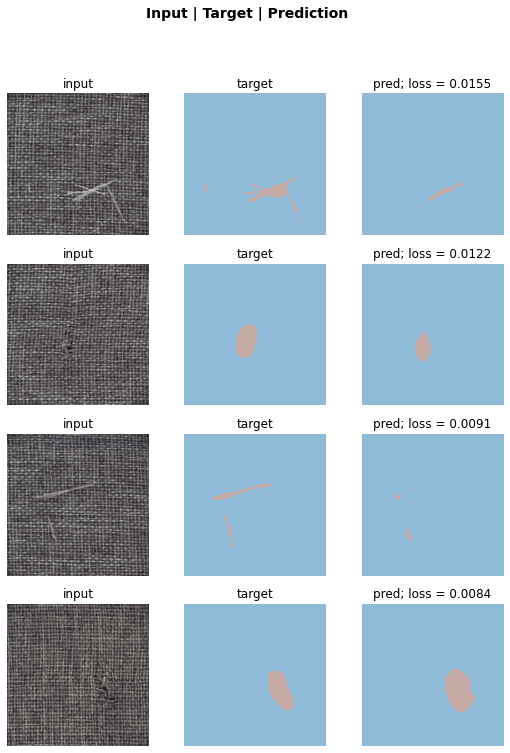

In [ ]:
interp.plot_top_losses(4)

Ensembling could be done to boost performance some more. Saveing Best 